In [ ]:
import os
import warnings

warnings.filterwarnings(action='ignore', message='numpy.dtype size changed')
warnings.filterwarnings(action='ignore', message='compiletime version 3.5 of module')

if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
os.chdir(os.path.split(workbookDir)[0])

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from scipy.stats import ks_2samp
import seaborn as sns
from synthesized import BasicSynthesizer
from synthesized.testing.synthetic_distributions import *
from synthesized.testing.synthetic_distributions import _plot_data

In [ ]:
def log_values(synthesizer):
    print(' ', 'value types:')
    for value in synthesizer.values:
        print(' ', value.name, value)
    print()

def log_distance(df_original, df_synthesized):
    distances = list()
    for name in df_original:
        distance = ks_2samp(df_original[name], df_synthesized[name]).statistic
        suffix = ''
        if distance < 0.05:
            suffix += '*'
        if distance < 0.01:
            suffix += '*'
        distances.append('{:.3f}{}'.format(distance, suffix))
    print('/'.join(distances), end='  ')

In [ ]:
size = 100000

def synthesize(df_original, num_iterations, num_logging, fn_logging=log_distance, **kwargs):
    start = time.time()
    with BasicSynthesizer(df=df_original, **kwargs) as synthesizer:
        log_values(synthesizer)
        value_types = {value.name: type(value) for value in synthesizer.values}
        df_synthesized = synthesizer.synthesize(num_rows=len(df_original))
        fn_logging(df_original, df_synthesized)
        for _ in range(num_iterations // num_logging):
            synthesizer.learn(df_train=df_original, num_iterations=num_logging)
            df_synthesized = synthesizer.synthesize(num_rows=len(df_original))
            assert len(df_synthesized) == len(df_original)
            fn_logging(df_original, df_synthesized)
        print()
        print(' ', 'took', time.time() - start, 's')
        return synthesizer.synthesize(num_rows=len(df_original)), value_types

def plot(data, synthesized, value_types):
#     distances = [ks_2samp(data[col], synthesized[col])[0] for col in data.columns]
#     avg_distance = np.mean(distances)
#     evaluation[name + '_avg_distance'] = avg_distance
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
    ax1.set_title('original')
    ax2.set_title('synthesized')
    _plot_data(data, ax=ax1, value_types=value_types)
    _plot_data(synthesized, ax=ax2, value_types=value_types)

## 1. Single-column categorical

Interesting hyperparameters: entropy regularization, learning rate and decay, beta loss.

Only change between different categorical distributions: entropy regularization.

### (a) Bernoulli(0.3)

In [ ]:
df_original = create_bernoulli(probability=0.3, size=size)
df_synthesized, value_types = synthesize(
    df_original=df_original, summarizer='summaries', num_iterations=1000, num_logging=20,
    # VAE distribution
    distribution='normal', latent_size=512,
    # Network
    network='mlp', capacity=256, depth=4, batchnorm=True, activation='relu',
    # Optimizer
    optimizer='adam', learning_rate=1e-3, decay_steps=300, decay_rate=0.5,
    initial_boost=True, clip_gradients=1.0, batch_size=128,
    # Losses
    categorical_weight=5.0, continuous_weight=1.0, beta=0.04, weight_decay=0.0,
    # Categorical
    temperature=0.7, smoothing=0.0, moving_average=False,
    similarity_regularization=0.0, entropy_regularization=0.0
)

### (b) Bernoulli(0.1)

In [ ]:
df_original = create_bernoulli(probability=0.1, size=size)
df_synthesized, value_types = synthesize(
    df_original=df_original, summarizer='summaries', num_iterations=1000, num_logging=20,
    # VAE distribution
    distribution='normal', latent_size=512,
    # Network
    network='mlp', capacity=256, depth=4, batchnorm=True, activation='relu',
    # Optimizer
    optimizer='adam', learning_rate=1e-3, decay_steps=300, decay_rate=0.5,
    initial_boost=True, clip_gradients=1.0, batch_size=128,
    # Losses
    categorical_weight=5.0, continuous_weight=1.0, beta=0.04, weight_decay=0.0,
    # Categorical
    temperature=0.7, smoothing=0.0, moving_average=False,
    similarity_regularization=0.0, entropy_regularization=0.0
)

### (c) Categorical([0.5, 0.25, 0.125, ...])

In [ ]:
df_original = create_categorical(probabilities=[0.5, 0.25, 0.125, 0.0625, 0.0625], size=size)
df_synthesized, value_types = synthesize(
    df_original=df_original, summarizer='summaries', num_iterations=1000, num_logging=20,
    # VAE distribution
    distribution='normal', latent_size=512,
    # Network
    network='mlp', capacity=256, depth=4, batchnorm=True, activation='relu',
    # Optimizer
    optimizer='adam', learning_rate=1e-3, decay_steps=300, decay_rate=0.5,
    initial_boost=True, clip_gradients=1.0, batch_size=128,
    # Losses
    categorical_weight=5.0, continuous_weight=1.0, beta=0.04, weight_decay=0.0,
    # Categorical
    temperature=0.7, smoothing=0.0, moving_average=False,
    similarity_regularization=0.0, entropy_regularization=0.0
)

## 2. Single-column continuous

Interesting hyperparameters: learning rate and decay, beta loss

### (a) Gaussian(0, 1)

In [ ]:
df_original = create_1d_gaussian(mean=0.0, std=1.0, size=size)
df_synthesized, value_types = synthesize(
    df_original=df_original, summarizer='summaries', num_iterations=1000, num_logging=20,
    # VAE distribution
    distribution='normal', latent_size=512,
    # Network
    network='mlp', capacity=256, depth=4, batchnorm=True, activation='relu',
    # Optimizer
    optimizer='adam', learning_rate=1e-3, decay_steps=300, decay_rate=0.5,
    initial_boost=True, clip_gradients=1.0, batch_size=128,
    # Losses
    categorical_weight=5.0, continuous_weight=1.0, beta=0.04, weight_decay=0.0,
    # Categorical
    temperature=0.7, smoothing=0.0, moving_average=False,
    similarity_regularization=0.0, entropy_regularization=0.0
)

### (b) Gaussian mixture N(0, 1) and N(3, 1)

Please note that fitting of distributions is not stable and for the same parameters of original distribution we can get a different fitted distribution. We actually should not fit any distribution in this case. Shouldn't we decrease threshold for distribution fitting?

In [ ]:
df_original = create_two_gaussian_mixtures(mean1=0.0, std1=1.0, mean2=3.0, std2=1.0, size=size)
df_synthesized, value_types = synthesize(
    df_original=df_original, summarizer='summaries', num_iterations=1000, num_logging=20,
    # VAE distribution
    distribution='normal', latent_size=512,
    # Network
    network='mlp', capacity=256, depth=4, batchnorm=True, activation='relu',
    # Optimizer
    optimizer='adam', learning_rate=1e-3, decay_steps=300, decay_rate=0.5,
    initial_boost=True, clip_gradients=1.0, batch_size=128,
    # Losses
    categorical_weight=5.0, continuous_weight=1.0, beta=0.04, weight_decay=0.0,
    # Categorical
    temperature=0.7, smoothing=0.0, moving_average=False,
    similarity_regularization=0.0, entropy_regularization=0.0
)

#### (i) Production-like settings which sould produce reasonable result

In [ ]:
df_original = create_two_gaussian_mixtures(mean1=0.0, std1=1.0, mean2=3.0, std2=1.0, size=size)
df_synthesized, value_types = synthesize(
    df_original=df_original, summarizer='summaries', num_iterations=5000, num_logging=100,
    # VAE distribution
    distribution='normal', latent_size=128,
    # Network
    network='mlp', capacity=128, depth=2, batchnorm=True, activation='relu',
    # Optimizer
    optimizer='adam', learning_rate=3e-4, decay_steps=1000, decay_rate=0.9,
    clip_gradients=1.0, batch_size=64,
    # Losses
    categorical_weight=1.0, continuous_weight=1.0, beta=0.001, weight_decay=1e-5,
    # Categorical
    temperature=1.0, smoothing=0.1, moving_average=True,
    similarity_regularization=0.1, entropy_regularization=0.1
)

In [ ]:
df_original.hist(bins=100)
df_synthesized.hist(bins=100)

## 3. Two-column product distributions

### (a) Bernoulli(0.1) x Bernoulli(0.1)

Same hyperparameters as for single-column case, but slightly increased entropy regularization value.

In [ ]:
df_original = product(
    df1=create_bernoulli(probability=0.1, size=size),
    df2=create_bernoulli(probability=0.1, size=size)
)
df_synthesized, value_types = synthesize(
    df_original=df_original, summarizer='summaries', num_iterations=1000, num_logging=20,
    # VAE distribution
    distribution='normal', latent_size=512,
    # Network
    network='mlp', capacity=256, depth=4, batchnorm=True, activation='relu',
    # Optimizer
    optimizer='adam', learning_rate=1e-3, decay_steps=300, decay_rate=0.5,
    initial_boost=True, clip_gradients=1.0, batch_size=128,
    # Losses
    categorical_weight=5.0, continuous_weight=1.0, beta=0.04, weight_decay=0.0,
    # Categorical
    temperature=0.7, smoothing=0.0, moving_average=False,
    similarity_regularization=0.0, entropy_regularization=0.0
)

### (b) Gaussian(1, 1) x Gaussian(-1, 1)

In [ ]:
df_original = product(
    df1=create_1d_gaussian(mean=1.0, std=1.0, size=size),
    df2=create_1d_gaussian(mean=-1.0, std=1.0, size=size)
)
df_synthesized, value_types = synthesize(
    df_original=df_original, summarizer='summaries', num_iterations=1000, num_logging=20,
    # VAE distribution
    distribution='normal', latent_size=512,
    # Network
    network='mlp', capacity=256, depth=4, batchnorm=True, activation='relu',
    # Optimizer
    optimizer='adam', learning_rate=1e-3, decay_steps=300, decay_rate=0.5,
    initial_boost=True, clip_gradients=1.0, batch_size=128,
    # Losses
    categorical_weight=5.0, continuous_weight=1.0, beta=0.04, weight_decay=0.0,
    # Categorical
    temperature=0.7, smoothing=0.0, moving_average=False,
    similarity_regularization=0.0, entropy_regularization=0.0
)

### (c) Bernoulli x Gaussian

In [14]:
df_original = product(
    df1=create_bernoulli(probability=0.1, size=size),
    df2=create_1d_gaussian(mean=0.0, std=1.0, size=size)
)
df_synthesized, value_types = synthesize(
    df_original=df_original, summarizer='summaries', num_iterations=1000, num_logging=20,
    # VAE distribution
    distribution='normal', latent_size=512,
    # Network
    network='mlp', capacity=256, depth=4, batchnorm=True, activation='relu',
    # Optimizer
    optimizer='adam', learning_rate=1e-3, decay_steps=300, decay_rate=0.5,
    initial_boost=True, clip_gradients=1.0, batch_size=128,
    # Losses
    categorical_weight=5.0, continuous_weight=1.0, beta=0.04, weight_decay=0.0,
    # Categorical
    temperature=0.7, smoothing=0.0, moving_average=False,
    similarity_regularization=0.0, entropy_regularization=0.0
)

  value types:
  x1 categorical2-140
  x2 continuous-weibull

0.176/0.388  0.021*/0.060  0.005**/0.025*  0.023*/0.066  0.030*/0.022*  0.025*/0.043*  0.021*/0.058  0.013*/0.028*  0.009**/0.040*  0.003**/0.028*  0.002**/0.020*  0.026*/0.031*  0.030*/0.034*  0.028*/0.020*  0.006**/0.018*  0.010**/0.038*  0.018*/0.022*  0.024*/0.021*  0.016*/0.025*  0.025*/0.023*  0.028*/0.014*  0.029*/0.034*  0.017*/0.030*  0.010*/0.022*  0.022*/0.029*  0.025*/0.036*  0.030*/0.032*  0.016*/0.025*  0.012*/0.026*  0.015*/0.022*  0.021*/0.045*  0.022*/0.026*  0.031*/0.030*  0.034*/0.036*  0.028*/0.016*  0.022*/0.028*  0.019*/0.026*  0.017*/0.023*  0.018*/0.035*  0.013*/0.020*  0.010**/0.030*  0.017*/0.022*  0.022*/0.042*  0.017*/0.042*  0.012*/0.030*  0.009**/0.019*  0.009**/0.028*  0.006**/0.028*  0.013*/0.018*  0.017*/0.024*  0.023*/0.034*  
  took 86.21621990203857 s


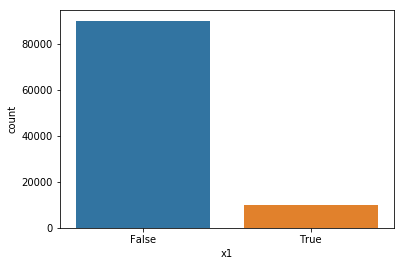

In [15]:
sns.countplot(df_original['x1'])

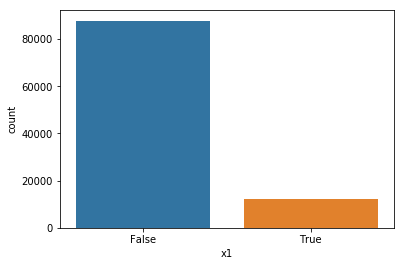

In [16]:
sns.countplot(df_synthesized['x1'])

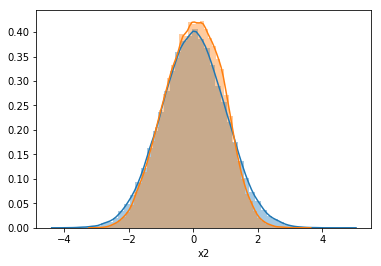

In [17]:
sns.distplot(df_original['x2'])
sns.distplot(df_synthesized['x2'])